In [1]:
import networkx as nx
import pandas as pd
import glob 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm

## 1. Compute structure measures and centrality measures

In [2]:
df_char = pd.read_csv("data/char_cleaned.csv")
GCPS_L1 = list(df_char[df_char['GCPS_GRADE'] == 1]['token'])
GCPS_L2 = list(df_char[df_char['GCPS_GRADE'] == 2]['token'])
GCPS_L3 = list(df_char[df_char['GCPS_GRADE'] == 3]['token'])
GCPS_L4 = list(df_char[df_char['GCPS_GRADE'] == 4]['token'])

In [3]:
np.shape(df_char)

(303, 26)

In [4]:
print( "Grade-1 : {}".format(len(df_char[df_char['GCPS_GRADE'] == 1])))
print( "Grade-2 : {}".format(len(df_char[df_char['GCPS_GRADE'] == 2])))
print( "Grade-3 : {}".format(len(df_char[df_char['GCPS_GRADE'] == 3])))
print( "Grade-4 : {}".format(len(df_char[df_char['GCPS_GRADE'] == 4])))

Grade-1 : 21
Grade-2 : 33
Grade-3 : 67
Grade-4 : 182


In [5]:
def get_struct_vec():
    struct_vec = []
    for index, row in df_char.iterrows():
        node_id = row['token']
        filename = 'Ego_networks/' + node_id + '.csv'
        G = nx.read_edgelist(filename, delimiter=',', create_using=nx.Graph, data = (('edge_type', str),))
        clu = nx.clustering(G, node_id)
        clo = nx.closure(G, node_id)[0]
        i_quad = nx.inner_quadrangle_coefficient(G, node_id)
        clu_3 = nx.order_three_clustering_coef(G, node_id)[node_id]      
        struct_vec.append([clu, clo, i_quad, clu_3])
    return np.array(struct_vec)

In [6]:
def get_centrality_vec():
    centrality_vec = []
    for index, row in df_char.iterrows():
        node_id = row['token']
        filename = 'Ego_networks/' + node_id + '.csv'
        G = nx.read_edgelist(filename, delimiter=',', create_using=nx.Graph, data = (('edge_type', str),))
        deg = G.degree[node_id] / 10
        btw = nx.betweenness_centrality(G)[node_id]
        eig = nx.eigenvector_centrality(G)[node_id]
        
        centrality_vec.append([deg, btw, eig])
    return np.array(centrality_vec)

In [7]:
struct_vec = get_struct_vec()
print(np.shape(struct_vec))

centrality_vec = get_centrality_vec()
print(np.shape(centrality_vec))

struct_and_centrality = np.concatenate((struct_vec, centrality_vec), axis=1)
print(np.shape(struct_and_centrality))

(303, 4)
(303, 3)
(303, 7)


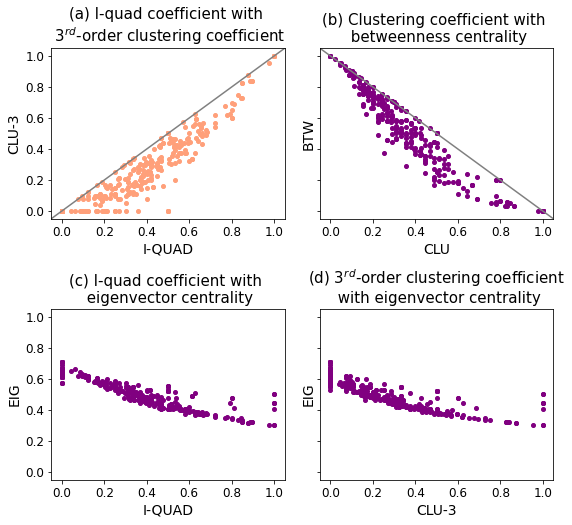

In [8]:
clu3 = struct_vec[:, 3]
iquad = struct_vec[:, 2]
clu = struct_vec[:, 0]
clo = struct_vec[:, 1]
btw = centrality_vec[:, 1]
eig = centrality_vec[:, 2]

onepic, axes = plt.subplots(2,2,figsize=(9,7.94), sharey=True)
plt.subplots_adjust(hspace=0.53, wspace=.15) 
axes[0,0].plot(iquad, clu3, 'o', c="lightsalmon", markersize=4)
axes[0,0].plot([0, 1], [0, 1], color='gray', transform=axes[0,0].transAxes)
axes[0,0].set_title("(a) I-quad coefficient with \n $3^{rd}$-order clustering coefficient", fontsize = 15)
axes[0,0].set_xlabel("I-QUAD", fontsize = 14)
axes[0,0].set_ylabel("CLU-3", fontsize = 14)
axes[0,0].tick_params(axis='both', which='major', labelsize=12)

axes[0,1].plot(clu, btw, 'o', c="purple", markersize=4)
axes[0,1].plot([0, 1], [1, 0], color='gray', transform=axes[0,1].transAxes)
axes[0,1].set_title("(b) Clustering coefficient with \n betweenness centrality", fontsize = 15)
axes[0,1].set_xlabel("CLU", fontsize = 14)
axes[0,1].set_ylabel("BTW", fontsize = 14)
axes[0,1].tick_params(axis='both', which='major', labelsize=12)

axes[1, 0].plot(iquad, eig, 'o', c="purple", markersize=4)
# axes[2].plot([0, 1], [1, 0], color='gray')
axes[1, 0].set_title("(c) I-quad coefficient with \n eigenvector centrality", fontsize = 15)
axes[1, 0].set_xlabel("I-QUAD", fontsize = 14)
axes[1, 0].set_ylabel("EIG", fontsize = 14)
axes[1, 0].tick_params(axis='both', which='major', labelsize=12)

axes[1, 1].plot(clu3, eig, 'o', c="purple", markersize=4)
axes[1, 1].set_title("(d) $3^{rd}$-order clustering coefficient \n with eigenvector centrality", fontsize = 15)
axes[1, 1].set_xlabel("CLU-3", fontsize = 14)
axes[1, 1].set_ylabel("EIG", fontsize = 14)
axes[1, 1].tick_params(axis='both', which='major', labelsize=12)
plt.savefig("scatter.pdf")

## 2. Correlation matrix and Parallel Coordinates Plot

In [9]:
df_strut = pd.DataFrame(data=struct_and_centrality, columns=["CLU", "CLO", "I-QUAD", "CLU-3", "DEG", "BTW", "EIG"])

In [10]:
df_strut['token'] = df_char['token']
df_strut = df_strut[['token', 'CLU', 'CLO', 'I-QUAD', 'CLU-3', 'DEG', 'BTW', 'EIG']]

In [11]:
df_strut
df_strut.to_csv("data_with_network_characteristics.csv")

In [12]:
G1 = nx.read_edgelist("Ego_networks/S104654P.csv", delimiter=',', create_using=nx.Graph, data = (('edge_type', str),))

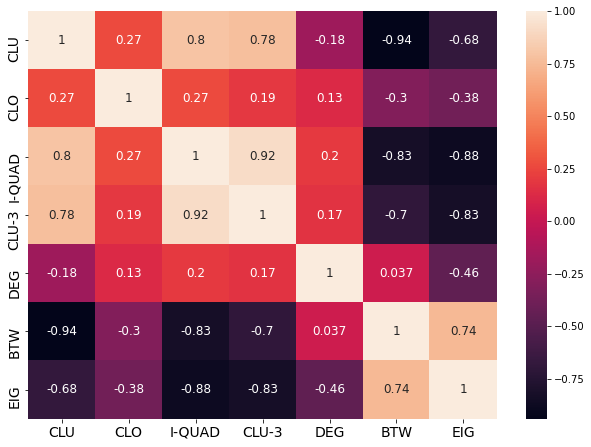

In [13]:
corr_matrix = df_strut.corr()
plt.figure(figsize = (10.5,7.5))
heatmap = sns.heatmap(corr_matrix, annot=True, annot_kws={"fontsize":12})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
heatmap.figure.savefig("corr_matrix_struct.pdf")

In [14]:
df_strut["GCPS_GRADE"] = df_char["GCPS_GRADE"]

In [15]:
group_mean = df_strut.groupby('GCPS_GRADE').mean()

In [16]:
group_mean["GCPS_GRADE"] = group_mean.index

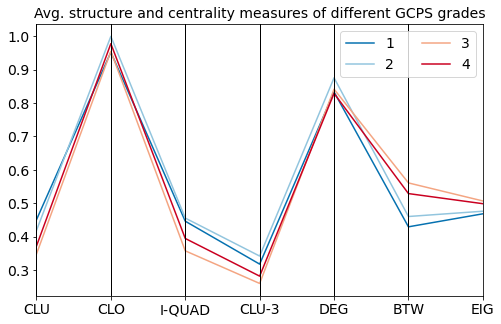

In [17]:
plt.figure(figsize=(8,5))
pd.plotting.parallel_coordinates(
    group_mean, 'GCPS_GRADE', color=('#0571b0','#92c5de','#f4a582', '#ca0020'), axvlines=True)
plt.grid(False)
plt.legend(fontsize=14, ncol=2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Avg. structure and centrality measures of different GCPS grades", fontsize=14)
plt.savefig("PCP.pdf")

## 3. Classification

In [18]:
def average_score_classification(clf, X, y, cv, repeat=100):
    res = 0 
    for i in range(repeat):  
        temp = cross_val_score(clf, X, y, cv=cv, scoring="f1_macro")
        res += np.mean(temp)
    return res/repeat

In [19]:
def average_score_classification_with_std(clf, X, y, cv, repeat=100):
    res = [] 
    for i in tqdm(range(repeat)):  
        temp = cross_val_score(clf, X, y, cv=cv, scoring="f1_macro")
        res.append(np.mean(temp))
    return np.mean(res), np.std(res)

## 4. Classification using both

In [21]:
X_struct = struct_vec
X_centrality = centrality_vec
X_struct_and_centrality = struct_and_centrality
print(np.shape(X_struct))
print(np.shape(X_centrality))
print(np.shape(X_struct_and_centrality))
y = df_char['GCPS_GRADE'].to_numpy()
print(np.shape(y))

(303, 4)
(303, 3)
(303, 7)
(303,)


In [22]:
X_char = df_char.drop(["token", "GCPS_GRADE"], axis=1).to_numpy()
X_char_struct = np.concatenate((X_char, X_struct),axis=1)
X_char_centrality = np.concatenate((X_char, X_centrality),axis=1)
X_char_struct_centrality = np.concatenate((X_char, X_struct_and_centrality),axis=1)

print(np.shape(X_char))
print(np.shape(X_char_struct))
print(np.shape(X_char_centrality))
print(np.shape(X_char_struct_centrality))

(303, 24)
(303, 28)
(303, 27)
(303, 31)


In [23]:
scaler = StandardScaler().fit(X_char)
X_char_scaled = scaler.transform(X_char)

scaler = StandardScaler().fit(X_char_struct)
X_char_struct_scaled = scaler.transform(X_char_struct)

scaler = StandardScaler().fit(X_char_centrality)
X_char_centrality_scaled = scaler.transform(X_char_centrality)

scaler = StandardScaler().fit(X_char_struct_centrality)
X_char_struct_centrality_scaled = scaler.transform(X_char_struct_centrality)

In [24]:
skf = StratifiedKFold(n_splits=5)
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=99)
clf_rf =  RandomForestClassifier(n_estimators=20, max_features=None, bootstrap=False, min_samples_leaf=2, min_samples_split=5)

In [25]:
clf_dummy = DummyClassifier(strategy='stratified')
print(average_score_classification_with_std(clf_dummy, X_struct, y, skf, repeat=500))

100%|██████████| 500/500 [00:03<00:00, 153.12it/s]

(0.24424345326103225, 0.02503599587002058)


In [26]:
char_mean, char_std = average_score_classification_with_std(clf_rf, X_char_scaled, y, skf, repeat=500)
char_struct_mean, char_struct_std = average_score_classification_with_std(clf_rf, X_char_struct_scaled, y, skf, repeat=500)
char_centrality_mean, char_centrality_std = average_score_classification_with_std(clf_rf, X_char_centrality_scaled, y, skf, repeat=500)
char_struct_centrality_mean, char_struct_centrality_std = average_score_classification_with_std(clf_rf, X_char_struct_centrality_scaled, y, skf, repeat=500)

100%|██████████| 500/500 [02:20<00:00,  3.56it/s]


In [27]:
print("Char:                        {:.3f} $\pm$ {:.4f}".format(char_mean, char_std))
print("Char + Struct:               {:.3f} $\pm$ {:.4f}".format(char_struct_mean, char_struct_std))
print("Char + Centrality:           {:.3f} $\pm$ {:.4f}".format(char_centrality_mean, char_centrality_std))
print("Char + Struct + Centrality:  {:.3f} $\pm$ {:.4f}".format(char_struct_centrality_mean, char_struct_centrality_std)) 

Char:                        0.578 $\pm$ 0.0050
Char + Struct:               0.610 $\pm$ 0.0072
Char + Centrality:           0.633 $\pm$ 0.0061
Char + Struct + Centrality:  0.648 $\pm$ 0.0072


### Draw Prototype

[0.45015117 0.95238095 0.44602719 0.31735593 0.83333333 0.42913706
 0.46815214]
[0.41810967 1.         0.45535596 0.34149103 0.87575758 0.46005852
 0.4759352 ]
[0.34741767 0.95522388 0.35717681 0.25943018 0.84179104 0.56072139
 0.50665501]
[0.3713806  0.97802198 0.3942666  0.28128601 0.82912088 0.52875303
 0.49845668]
{'Ego': [10, 29, 16, 37, 47, 27, 9]}
{'Ego': [8, 18, 10, 15, 27, 9, 5]}


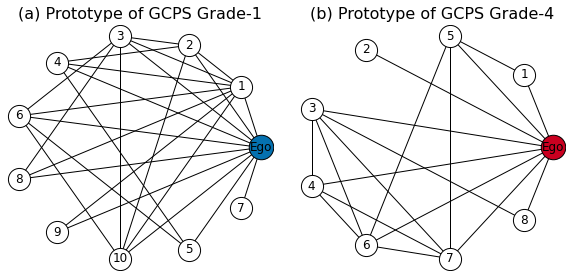

In [28]:
def LSM_CM_vector_ego(G, node_id):
    res = {}
    
    clu = nx.clustering(G, node_id)
    clo = nx.closure(G, node_id)[0]
    i_quad = nx.inner_quadrangle_coefficient(G, node_id)
    clu_3 = nx.order_three_clustering_coef(G, node_id)[node_id] 
    deg = G.degree[node_id] / 10
    btw = nx.betweenness_centrality(G)[node_id]
    eig = nx.eigenvector_centrality(G)[node_id]
    
    vec = [clu, clo, i_quad, clu_3, deg, btw, eig]
    res[node_id] = vec
    return res

def group_average_LSM_CM(patient_id_list):
    num = 0
    vec = np.zeros(7)
    for file in glob.glob('Ego_networks/*'):
        node_id = file[13:21]
        if (node_id in patient_id_list):
            num += 1
            G = nx.read_edgelist(file, delimiter=',', create_using=nx.Graph, data = (('edge_type', str),))
            dic = LSM_CM_vector_ego(G, node_id) 
#             print(node_id)
#             print(dic[node_id])
            vec = np.add(vec, dic[node_id]) 
    return vec / num

avg_lvl_1 = group_average_LSM_CM(GCPS_L1)
avg_lvl_2 = group_average_LSM_CM(GCPS_L2)
avg_lvl_3 = group_average_LSM_CM(GCPS_L3)
avg_lvl_4 = group_average_LSM_CM(GCPS_L4)
print(avg_lvl_1)
print(avg_lvl_2)
print(avg_lvl_3)
print(avg_lvl_4)

def calculate_distance(pain_grade):   
    dict_distance = {}
    for file in glob.glob('Ego_networks/*'):
        node_id = file[13:21]
        if (node_id in pain_grade):
            G = nx.read_edgelist(file, delimiter=',', create_using=nx.Graph, data = (('edge_type', str),))
            dic = LSM_CM_vector_ego(G, node_id)
            average = group_average_LSM_CM(pain_grade)
            distance = dic[node_id] - average
            distance = distance ** 2
            dict_distance[node_id] = np.sum(distance)
    # Sort the values      
    sorted_values = sorted(dict_distance.values()) 
    sorted_dict = {}

    for i in sorted_values:
        for k in dict_distance.keys():
            if dict_distance[k] == i:
                sorted_dict[k] = dict_distance[k]
                break    
    return sorted_dict

def draw_prototype(node_id, axe, egocolor):
    filename = node_id + '.csv'
    G = nx.read_edgelist(filename, delimiter=',', create_using=nx.Graph, data = (('edge_type', str),))
    print(nx.induced_graphlet_degree_vector_ego(G, "Ego"))
    pos = nx.circular_layout(G)
    nx.draw(G, pos, node_color="w", node_size=490, with_labels=True, edgecolors="k", ax=axe)
    
    # nx.draw_networkx_labels(G, pos, bbox=dict(boxstyle='circle', fc="w", ec="k"), font_size=12)
    options = {"node_size": 600, "node_color": egocolor}
    nx.draw_networkx_nodes(G, pos, nodelist=["Ego"], **options, edgecolors="k", ax=axe)

onepic, axes = plt.subplots(1,2,figsize=(10, 4.5))
plt.subplots_adjust(hspace=0.25, wspace=.1) 
draw_prototype('S108842P', axes[0], '#0571b0')
axes[0].set_title("(a) Prototype of GCPS Grade-1", fontsize=16)

draw_prototype('S104825P', axes[1], '#ca0020')
plt.savefig("prototype.pdf")
axes[1].set_title("(b) Prototype of GCPS Grade-4", fontsize=16)

plt.savefig("prototype.pdf")